In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [2]:
data = pd.read_csv("./wind_turbine_20220114.csv", encoding="latin1")

**PART-1:** EXPLORATORY DATA ANALYSES

KEY QUESTIONS:
1. How many columns are there?
2. What are the columns headers?
3. How the dataframe is arrage?
4. What data types are those columns?
5. Which columns nulls?

KEY OUTCOMES:
1. No nulls in my columns of interest, in this case project year.
2. Prepare a new dataset with a column "cumulative_number_of_windturbine)
3. Data ready for for a forecast modeling using ARIMA


In [3]:
data.shape  #KQ- 1|

(70808, 27)

In [4]:
data.columns #KQ- 2

Index(['case_id', 'faa_ors', 'faa_asn', 'usgs_pr_id', 'eia_id', 't_state',
       't_county', 't_fips', 'p_name', 'p_year', 'p_tnum', 'p_cap', 't_manu',
       't_model', 't_cap', 't_hh', 't_rd', 't_rsa', 't_ttlh', 'retrofit',
       'retrofit_year', 't_conf_atr', 't_conf_loc', 't_img_date', 't_img_srce',
       'xlong', 'ylat'],
      dtype='object')

The column names in this dataset too much abbreviated. If you want you can change all the column name to something that makes more sence to you but for now I am only going to chanege the column name for p_column and p_year

In [13]:
data.rename(columns={"p_year": "project_year", "p_name": "project_name"}, inplace=True)

In [15]:
data.head() #KQ- 3

,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,project_name,project_year,...,t_rsa,t_ttlh,retrofit,retrofit_year,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat
0,3072661,NaN,NaN,5149.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,0,NaN,2,3,5/8/2018,Digital Globe,-118.363762,35.077908
1,3072695,NaN,NaN,5143.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,0,NaN,2,3,5/8/2018,Digital Globe,-118.364410,35.077435
2,3072704,NaN,NaN,5146.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,0,NaN,2,3,5/8/2018,Digital Globe,-118.364197,35.077644
3,3063272,19-028134,2014-WTE-4084-OE,NaN,NaN,IA,Story County,19169,30 MW Iowa DG Portfolio,2017.0,...,12271.85,150.0,0,NaN,3,3,4/24/2017,Digital Globe,-93.430367,42.028233
4,3053390,19-028015,2015-WTE-6386-OE,NaN,NaN,IA,Boone County,19015,30 MW Iowa DG Portfolio,2017.0,...,12271.85,150.0,0,NaN,3,3,6/1/2017,Digital Globe,-93.700424,41.977608


In [16]:
data.info() #KQ- 4

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70808 entries, 0 to 70807
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   case_id        70808 non-null  int64  
 1   faa_ors        65016 non-null  object 
 2   faa_asn        65686 non-null  object 
 3   usgs_pr_id     38263 non-null  float64
 4   eia_id         65015 non-null  float64
 5   t_state        70808 non-null  object 
 6   t_county       70808 non-null  object 
 7   t_fips         70808 non-null  int64  
 8   project_name   70808 non-null  object 
 9   project_year   70195 non-null  float64
 10  p_tnum         70808 non-null  int64  
 11  p_cap          66326 non-null  float64
 12  t_manu         65168 non-null  object 
 13  t_model        65031 non-null  object 
 14  t_cap          65328 non-null  float64
 15  t_hh           64628 non-null  float64
 16  t_rd           64874 non-null  float64
 17  t_rsa          64874 non-null  float64
 18  t_ttlh

# Lets deal with the null value.
First let's see which columns have most null values

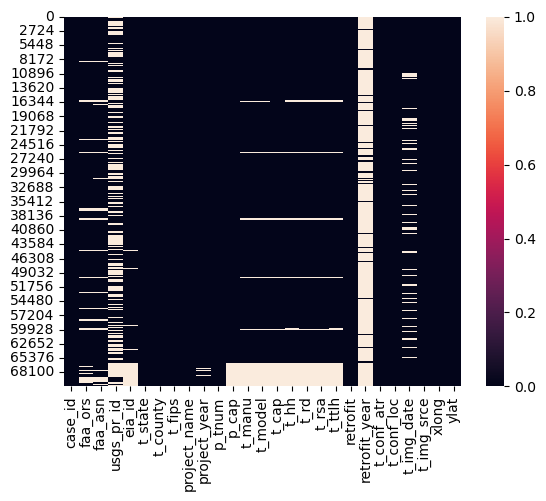

In [17]:
sns.heatmap(data.isnull());   #KQ- 5

Looks like there are some null value in project_year column, however their number look very few compared to the rest of dataset. So I am just going to delete those rows where project_year is null.


In [19]:
data.dropna(subset=["project_year"], inplace=True)


Lets take a look at the project_year column

In [20]:
data["project_year"]

0        1987.0
1        1987.0
2        1987.0
3        2017.0
4        2017.0
          ...  
70802    2021.0
70803    2016.0
70805    2011.0
70806    2016.0
70807    2016.0
Name: project_year, Length: 70195, dtype: float64

These years are float64 datatype. So let's convert them to a datetime object and have a yyyy-mm-dd

In [21]:
# pd.to_datetime(data["project_year"])
data["project_year"] = pd.to_datetime(data["project_year"], format="%Y")



Now let's see how the project_year column looks

In [22]:
data["project_year"]

0       1987-01-01
1       1987-01-01
2       1987-01-01
3       2017-01-01
4       2017-01-01
           ...    
70802   2021-01-01
70803   2016-01-01
70805   2011-01-01
70806   2016-01-01
70807   2016-01-01
Name: project_year, Length: 70195, dtype: datetime64[ns]

So now the data type is datetime64[ns] and the format looks exactly what I wanted.

In [12]:
# the following code prints the dataframe. but this dataframe is way too big to be printed so don't print this.
# print(data.to_string())

Now lets make a plot. I want to see a plot that shows the number of Wind Turbine added each year for the years in the dataset:

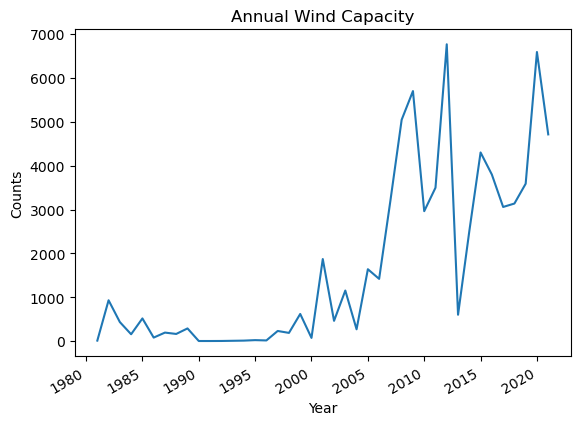

In [23]:
data.groupby("project_year")["case_id"].count().plot()
plt.title("Annual Wind Capacity")
plt.xlabel("Year")
plt.ylabel("Counts")
plt.show;

Now lets create a table where we will sum up the numbers of wind turbines that were established in the each year since 1982 and name the columns as "year" and "count".
We will use value_counts to aggregate the turbine number, then use sort values and finally reset_index in case there is a data missing. 

In [24]:
counts_in_years = data['project_year'].value_counts().sort_index().reset_index()
counts_in_years.columns = ['year', 'count']

Now let's make it a pandas dataframe:

In [67]:
df = pd.DataFrame(counts_in_years)
df

,year,count,cumulative_windturbine_num
0,1981-01-01,10,10
1,1982-01-01,930,940
2,1983-01-01,433,1373
3,1984-01-01,155,1528
4,1985-01-01,516,2044
5,1986-01-01,79,2123
6,1987-01-01,193,2316
7,1988-01-01,162,2478
8,1989-01-01,288,2766
9,1990-01-01,1,2767


# To forecast model of the cumulative number of the wind turbine lets create a cumulative column using cumsum() function

In [ ]:
df["cumulative_windturbine_num"] = df["count"].cumsum()
df

# Now lets create a predictive model using ARIMA model



To create a predictive model we need a continuous dataset with seasonality. let's create a column with the cumulative number of wind turbine and:

In [ ]:
# lets import adfller to test if the data is stationary or not
from statsmodels.tsa.stattools import adfuller

In [48]:
adf_results = adfuller(df["count"])
adf_results

(-0.39115576334690016,
 0.9115650083381044,
 2,
 37,
 {'1%': -3.6209175221605827,
  '5%': -2.9435394610388332,
  '10%': -2.6104002410518627},
 511.654591295898)

In [49]:
test_stat = adf_results[0]
test_stat

-0.39115576334690016

In [50]:
p_value = adf_results[1]
p_value

0.9115650083381044

In [51]:
critical_values = adf_results[4]
critical_values

{'1%': -3.6209175221605827,
 '5%': -2.9435394610388332,
 '10%': -2.6104002410518627}

In [52]:
df["cumulative_windturbine_num"] = df["count"].cumsum()

In [53]:
df

,count,cumulative_windturbine_num
year,,
1981-01-01,10,10
1982-01-01,930,940
1983-01-01,433,1373
1984-01-01,155,1528
1985-01-01,516,2044
1986-01-01,79,2123
1987-01-01,193,2316
1988-01-01,162,2478
1989-01-01,288,2766


Everything looks great lets set the year column as index:

In [54]:
df.set_index("year", inplace=True) 

KeyError: "None of ['year'] are in the columns"

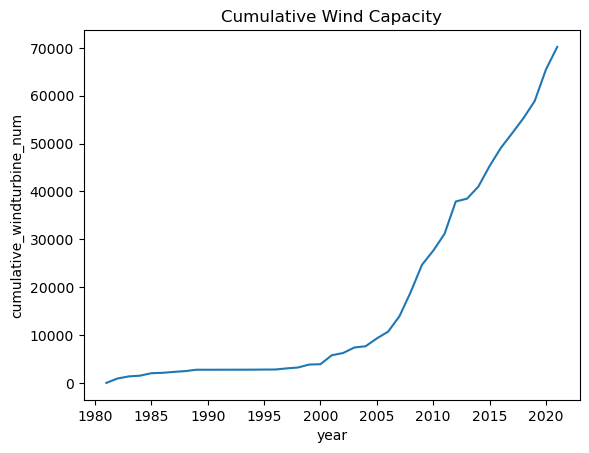

In [55]:
sns.lineplot(x= df.index, y="cumulative_windturbine_num", data=df)
# sns.lineplot(x= df.index, y="count", data=df)
plt.title("Cumulative Wind Capacity");

**Now time for some modeling:**

**Step 1:** import the from statsmodels.tsa.arima.model import ARIMA (it has been imported in the cell 1)
**Step 2:** resample the data on a yearly frequency.

In [62]:
adf_results = adfuller(df["cumulative_windturbine_num"])


In [63]:
test_stat = adf_results[0]
test_stat

2.9671504688306003

In [64]:
p_value = adf_results[1]
p_value

1.0

In [65]:
critical_values = adf_results[4]
critical_values

{'1%': -3.6155091011809297,
 '5%': -2.941262357486514,
 '10%': -2.6091995013850418}

In [20]:
growth_over_year = df.resample("Y")["cumulative_windturbine_num"].mean()

In [21]:
decomposition = seasonal_decompose(growth_over_year)
fig = plt.figure()
fig = decomposition.plot()

ValueError: This function does not handle missing values

lets check if where is the missing data

In [22]:
df.index

DatetimeIndex(['1982-01-01', '1983-01-01', '1984-01-01', '1985-01-01',
               '1986-01-01', '1987-01-01', '1988-01-01', '1989-01-01',
               '1990-01-01', '1991-01-01', '1992-01-01', '1994-01-01',
               '1995-01-01', '1996-01-01', '1997-01-01', '1998-01-01',
               '1999-01-01', '2000-01-01', '2001-01-01', '2002-01-01',
               '2003-01-01', '2004-01-01', '2005-01-01', '2006-01-01',
               '2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01',
               '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01',
               '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01'],
              dtype='datetime64[ns]', name='year', freq=None)

**Looking at the index it is clean that year 1993-01-01 is missing.**

In [23]:
df

,count,cumulative_windturbine_num
year,,
1982-01-01,930,930
1983-01-01,433,1363
1984-01-01,155,1518
1985-01-01,482,2000
1986-01-01,79,2079
1987-01-01,193,2272
1988-01-01,162,2434
1989-01-01,288,2722
1990-01-01,1,2723


Lets insert a row where count = 0 and cumulative_windturbine_num = 2726 since at the end ot 1992 the cumulative number wind turbine was 2726

In [24]:
new_row = {'count': 0,
           "cumulative_windturbine_num":2726}
new_date = pd.to_datetime('1993-01-01')

In [25]:
df.loc[new_date] = new_row

In [26]:
df.loc["1993-01-01"] #just checking

count                            0
cumulative_windturbine_num    2726
Name: 1993-01-01 00:00:00, dtype: int64

In [27]:
growth_over_year = df.resample("Y")["cumulative_windturbine_num"].mean()

<Figure size 640x480 with 0 Axes>

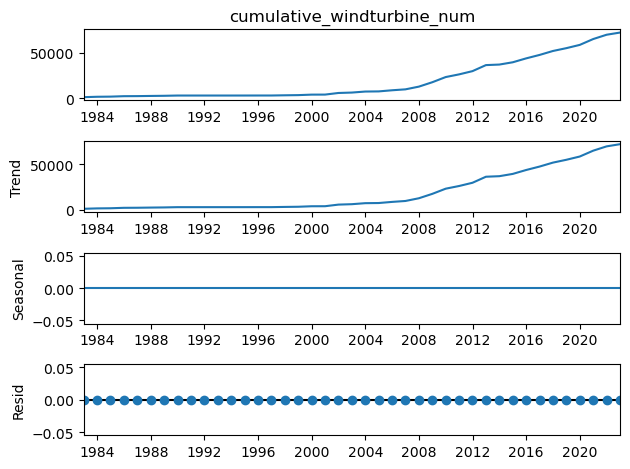

In [28]:
decomposition = seasonal_decompose(growth_over_year)
fig = plt.figure()
fig = decomposition.plot()

Lets divide this data set as train and test data

In [29]:
train = growth_over_year["1998-01-01": "2017-01-01"].astype(float)
test = growth_over_year["2017-01-01" : "2022-01-01"].astype(float)

Let's check out how does the test and train data look:

<AxesSubplot:xlabel='year'>

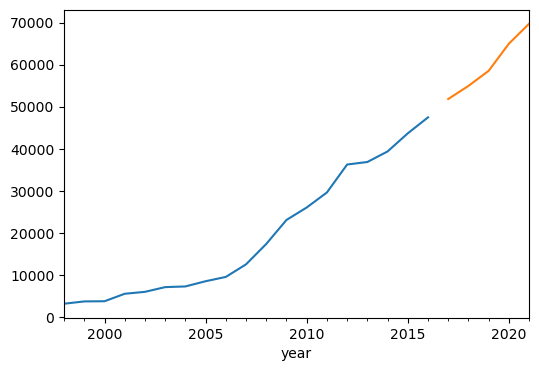

In [30]:
fig, ax = plt.subplots(figsize = (6,4))
train.plot()
test.plot()

Now we are finally ready to use ARIMA model to generate a prediction regarding the number of Wind Turbine by 2025. For this dataset I will use the following values for order=(1,1,1). These values are also known as p, d, q. Here the order=(1,1,1) means that we are using an ARIMA model with 1 autoregressive term, 1 differencing term, and 1 moving average term. When there is a apparent trend in the data the q = 1 (differencing term) is used.
Since our data has apparent trend I am using order=(1,1,1). In case no apparent trend I would have used order=(1,0,1).  

In [34]:
model = ARIMA(train, order=(1,1,1)).fit() 

/Users/chowdhury/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Now let's do get some predictions.

In [31]:
y_pred = model.predict(start="1998-01-01", end="2022-01-01")
fig, ax = plt.subplots(figsize=(8, 4))

/Users/chowdhury/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

Okay let's see what is going on and why the start argument could not be matched

In [36]:
train.index

DatetimeIndex(['1998-12-31', '1999-12-31', '2000-12-31', '2001-12-31',
               '2002-12-31', '2003-12-31', '2004-12-31', '2005-12-31',
               '2006-12-31', '2007-12-31', '2008-12-31', '2009-12-31',
               '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31',
               '2014-12-31', '2015-12-31', '2016-12-31'],
              dtype='datetime64[ns]', name='year', freq='A-DEC')

***Since we resampled the data at a yearly frequency. The training data index got set at the end of the year. So we just need to change the prediction start date and end date.***

In [42]:
y_pred = model.predict(start="2017-12-31", end="2025-12-31")

***Now let's plot:***

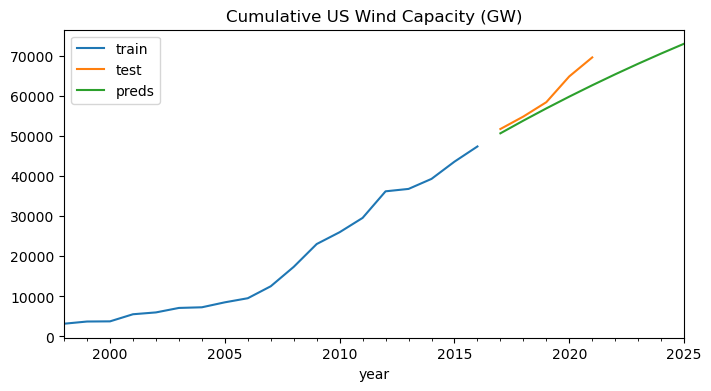

In [45]:
fig, ax = plt.subplots(figsize=(8, 4))
train.plot(label="train")
test.plot(label="test")
y_pred.plot(label="preds")
plt.title("Cumulative US Wind Capacity (GW)")
ax.legend();

With that there you go we have the prediction that capture the general trend in Cumulative US Wind Capacity

In [ ]:

# growth_over_year = new_data.resample("Y")["Cumulative US Wind Capacity (GW)"].mean()

# decomposition = seasonal_decompose(growth_over_year)
# fig = plt.figure()
# fig = decomposition.plot()

# # train = growth_over_year["1998-01-01": "2017-01-01"].astype(float)
# # test = growth_over_year["2017-01-01" : "2021-01-01"].astype(float)

# fig, ax = plt.subplots(figsize = (6,4))
# train.plot()
# test.plot()

# model = ARIMA(train, order=(1,1,1)).fit()  # Corrected parentheses
# y_pred = model.predict(start="1998-12-31", end="2023-12-31")
# fig, ax = plt.subplots(figsize=(8, 4))  # Removed extra spaces

# train.plot(label="train")
# test.plot(label="test")
# y_pred.plot(label="preds")
# plt.title("Cumulative US Wind Capacity (GW)")
# ax.legend()


In [ ]:
df